In [2]:
#Importing libraries
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
import math

from DataPreprocessing import Preprocessing
from CNN import ResNet15, ResNet9


In [3]:
directory = 'dataset'

data = Preprocessing(path={ 'test':directory+'/test',
                            'train':directory+'/train'})

In [4]:
train_ds, test_ds = data.preprocessed_dataset()

# spiltting and creating batches of data
batch_size = 5
val_size = math.ceil(len(test_ds) * 20/100)
test_size = len(test_ds) - val_size

# splitting the data
val_ds, test_ds = random_split(test_ds, [val_size, test_size])

# creating data loader
train_dl = DataLoader(  train_ds, 
                        batch_size,
                        num_workers = 3,
                        shuffle = True,
                        pin_memory = True)

val_dl = DataLoader(    val_ds,
                        batch_size,
                        num_workers = 3,
                        pin_memory = True)


x, y = next(iter(train_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 1, 128, 128])

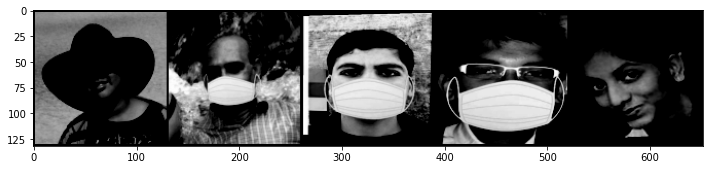

In [5]:
# visualizing
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(make_grid(x[:10], nrow=10).permute(1,2,0))
x.shape

In [6]:
# activate cuda
#device = torch.device('cuda'  if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(device)

cpu


In [7]:
model = ResNet15(1,2).to(device)

In [8]:
def get_lr(optimizer):
    """
    params: optimizer: optimizer of the mode
    return: learning rate
    """
    for x in optimizer.param_groups:
        return x['lr']

In [9]:
def fit(model, epochs, max_lr, train_dl, val_dl, weight_decay=0,
               optim = torch.optim.Adam, grad_clip=None):
    """
    Arguments:
    
    model --> CNN model
    epochs --> number of epoch
    max_lr --> max learning rate for one-cycle lr schedule
    train_dl, val_dl --> training and validation dataloader
    weight_decay --> regularizing parametric (reduces the weights to avoid overfitting)
    
    optim --> optimizer
    grad_clip --> regularizing parametric (limit the values of gradients to a small range)
    
    
    Return:
    history --> {
                    training_loss --> training loss for every epochs
                    validation_loss --> validation loss for every epochs
                    validation_acc --> validation accuracy for every epochs
    }
    """
    
    model.train() # training
    torch.cuda.empty_cache() #releases cache memory improves performance
    
    # defining optimizer and loss
    optimizer = optim(model.parameters(), max_lr, weight_decay = weight_decay)
    criterion = nn.NLLLoss()
    
    # one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, 
                                               steps_per_epoch = len(train_dl), epochs = epochs)
    
    
    val_loss_min = np.inf # initial value at infinity
    history = {
        'training_loss': [], #training loss for every epochs
        'validation_loss': [], #validation loss for every epochs
        'validation_acc': [], #validation accuracy for every epochs
        'learning_rates': [] #lr for every epochs   
        }
     
    for epoch in range(epochs):

        batch_train_loss = 0 #training loss for every batch
        batch_val_loss = 0 #validation loss for every batch
        batch_val_acc = 0 #valdation acc for every batch

        #looping through training dataloader
        for imgs, labels in train_dl:

            #Sending images and labels to GPU
            imgs, labels = imgs.to(device), labels.to(device)

            predictions = model(imgs)
            loss = criterion(predictions, labels)
            batch_train_loss += loss
            loss.backward()

            #gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
            optimizer.step()
            optimizer.zero_grad()
            
            #record and update lr
            history['learning_rates'].append(get_lr(optimizer))
            sched.step()

        #shutting down the gradients
        with torch.no_grad():
            model.eval() #for evaluating

            #looping through validation dataloader
            for imgs, labels in val_dl:
                #Sending images and labels to GPU
                imgs, labels = imgs.to(device), labels.to(device)

                predictions = model(imgs)
                loss = criterion(predictions, labels)              

                #Converting predictions to probabilities
                prob = torch.exp(predictions)
                #Finding the index of maximum probability
                _, index = torch.max(prob, dim=1)
                
                batch_val_loss += loss.item()
                batch_val_acc += torch.sum(index == labels).item() / len(index)
        
        #loss and accuracy per epoch
        training_loss = batch_train_loss / len(train_dl)
        val_loss = batch_val_loss / len(val_dl)
        val_acc = batch_val_acc / len(val_dl)

        history['training_loss'].append(training_loss)
        history['validation_loss'].append(val_loss)
        history['validation_acc'].append(val_acc)

        #Verbose
        print('Epochs: {}, training_loss: {:.4f}, val_loss: {:.4f},\
 val_acc: {:.4f}'.format(epoch, training_loss, val_loss, val_acc))
        
        if val_loss <= val_loss_min:
            '''
            Initailly the val_loss_min is set at infinity and gets 
            updated each time val_loss is lesser than val_loss_min.
            Basically it saves the model with least validation loss.
            '''            
            torch.save(model.state_dict(), 'state_dict_resnet15.pth')
            print('{} --> {}. Saving ...'.format(val_loss_min, val_loss))
            val_loss_min = val_loss

    return history
    

In [ ]:
history = fit(model, 10, 0.0001, train_dl, val_dl, weight_decay=0.01, 
        optim = torch.optim.Adam, grad_clip = 0.1)

/home/berkay/miniconda3/envs/mask_and_social/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
training_loss = history['training_loss']
val_loss = history['validation_loss']
val_acc = history['validation_acc']
lr = history['learning_rates']

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(val_loss, 'b-1', markersize=12, markeredgewidth=3
         , linewidth=2,label='val_loss')
plt.plot(val_acc, 'r--x', markersize=8, markeredgewidth=3
         , linewidth=3,label='val_acc')
plt.plot(training_loss, 'c-1', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_loss')
plt.grid()
plt.legend(loc='center right')

In [ ]:
plt.plot(lr,'r', label='lr')
plt.legend()